In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

In [3]:
import torch
from torch import nn

In [4]:
torch.manual_seed(52)

In [5]:
import os
import sys
import tqdm

In [6]:
# Add parent dir to interpreter path
nb_dir = os.path.split(os.getcwd())[0]
print("Notebook dir {:}".format(nb_dir))
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
print("Python interpreter path:")
for path in sys.path:
    print(path)

Notebook dir /home/manifold/Documents/etudes/map511-p3a
Python interpreter path:

/home/manifold/Documents/etudes/map511-p3a/notebooks
/home/manifold/miniconda3/envs/pytorch/lib/python37.zip
/home/manifold/miniconda3/envs/pytorch/lib/python3.7
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/lib-dynload
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/pointprocesses-0.4.1-py3.7-linux-x86_64.egg
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/torchvision-0.2.1-py3.7.egg
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/IPython/extensions
/home/manifold/.ipython
/home/manifold/Documents/etudes/map511-p3a


# Loading synthetic data

We will be loading simulated Hawkes data.

In [163]:
import glob
import pickle

SYNTH_DATA_FILES = glob.glob('../data/simulated/*')
print("Available files:")
for s in SYNTH_DATA_FILES:
    print(s)

from utils.load_synth_data import process_loaded_sequences, one_hot_embedding

Available files:
../data/simulated/hawkes_synth_data_1d.pkl
../data/simulated/hawkes_synth_data_2d.pkl
../data/simulated/README.md


In [173]:
process_dim = 2
# Load data simulated using tick
print("Loading {}-dimensional Hawkes data.".format(process_dim))
choose_file_index = 1
chosen_file = SYNTH_DATA_FILES[choose_file_index]
print("Data file: {}".format(chosen_file))
with open(SYNTH_DATA_FILES[process_dim-1], "rb") as f:
    loaded_hawkes_data = pickle.load(f)

print(loaded_hawkes_data.keys())

mu = loaded_hawkes_data['mu']
alpha = loaded_hawkes_data['alpha']
decay = loaded_hawkes_data['decay']
tmax = loaded_hawkes_data['tmax']
print("mu\t{:}".format(str(mu)))
print("decay\t{:}".format(str(decay)))
print("tmax\t{:}".format(tmax))

times_tensor, seq_types, seq_lengths = process_loaded_sequences(
    loaded_hawkes_data)

onehot_types = one_hot_embedding(seq_types, process_dim+1)

Loading 2-dimensional Hawkes data.
Data file: ../data/simulated/hawkes_synth_data_2d.pkl
dict_keys(['mu', 'alpha', 'decay', 'tmax', 'timestamps', 'types', 'lengths'])
mu	[0.7 1. ]
decay	0.01
tmax	60.0


# Neural network

We are going for a recurrent neural structure that can learn from previous events. The intensity process of our neural model will be of the form

$$
    \lambda_t = f\left(W_{\lambda} h(t)\right)
$$

with $f$ a positive-valued activation function (such as ReLU) and $h(t)\in\mathbb R^D$ a continuous hidden state, computed as
\begin{equation}
    h(t) = h_{i}e^{-\delta_i(t-t_{i-1})},\quad \forall t\in(t_{i-1},t_i]
\end{equation}

Network update formulas: the jump and decay parameters on $(t_i,t_{i+1}]$ are given by
$$
\begin{align*}
    h_{i+1}      &= \tanh(W_{hh}h(t_i) + W_{xh}x_i + b_{h}) \\
    \delta_{i+1} &= \sigma(W_{hd} h(t_i) + W_{xd}x_i + b_{d})
\end{align*}
$$

In [178]:
from models.decayrnn import HawkesDecayRNN, generate_sequence
from train_functions import train_decayrnn, plot_loss
process_dim = 2
hidden_size = 12
model = HawkesDecayRNN(process_dim, hidden_size, intens_bias=True)
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.018)

In [179]:
# define training data
train_size = 1200
print("Train size %d" % train_size)

train_times_tensor = times_tensor[:, :train_size]
train_onehot_types = onehot_types[:, :train_size]
train_seq_lengths = seq_lengths[:train_size]
print("Train event times shape {}".format(train_times_tensor.shape))
print("Train event types shape {}".format(train_onehot_types.shape))
print("Train seq lengths shape {}".format(train_seq_lengths.shape))

Train size 1200
Train event times shape torch.Size([167, 1200])
Train event types shape torch.Size([167, 1200, 3])
Train seq lengths shape torch.Size([1200])


In [180]:
# Training parameters
BATCH_SIZE = 24
EPOCHS = 20

loss_hist = train_decayrnn(model, optimizer, train_times_tensor,
                           train_onehot_types, train_seq_lengths, tmax,
                           BATCH_SIZE, EPOCHS, use_jupyter=True)

Batch size 24
Number of epochs 20


epoch 1: train loss 89.6435


epoch 2: train loss 50.6195


epoch 3: train loss 39.8087


epoch 4: train loss 36.2952


epoch 5: train loss 34.9283


epoch 6: train loss 34.2858


epoch 7: train loss 33.9343


epoch 8: train loss 33.7154


epoch 9: train loss 33.5714


epoch 10: train loss 33.4671


epoch 11: train loss 33.3865


epoch 12: train loss 33.3216


epoch 13: train loss 33.2723


epoch 14: train loss 33.2322


epoch 15: train loss 33.1931


epoch 16: train loss 33.1650


epoch 17: train loss 33.1384


epoch 18: train loss 33.1158


epoch 19: train loss 33.0954


epoch 20: train loss 33.0754


In [181]:
model.trained_epochs

20

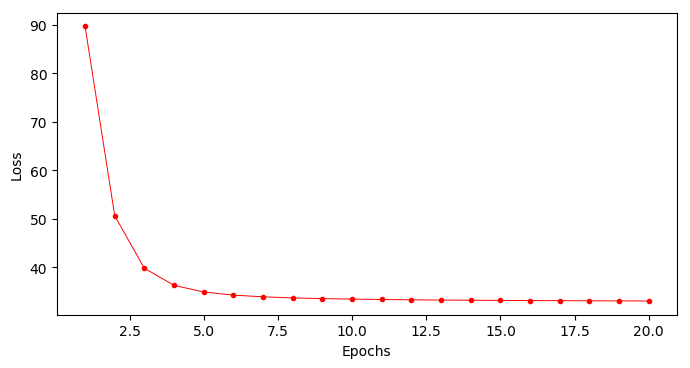

In [182]:
_ = plot_loss(EPOCHS, loss_hist)

## Save to file

In [184]:
import datetime

# Model file dump
SAVED_MODELS_PATH = os.path.abspath('saved_models')
os.makedirs(SAVED_MODELS_PATH, exist_ok=True)
# print("Saved models directory: {}".format(SAVED_MODELS_PATH))

date_format = "%Y%m%d-%H%M%S"
now_timestamp = datetime.datetime.now().strftime(date_format)
extra_tag = "{}d".format(process_dim)
filename_base = "{}-{}-{}".format(model.__class__.__name__, extra_tag, now_timestamp)
filename_model_save = filename_base + ".pth"
filepath = os.path.join(SAVED_MODELS_PATH, filename_model_save)
print("Saving model state dict to {}".format(filepath))
torch.save(model.state_dict(), filepath)

Saving model state dict to /home/manifold/Documents/etudes/map511-p3a/notebooks/saved_models/HawkesDecayRNN-2d-20181128-145645.pth


## Model evaluation

Now we perform model evaluation steps.

### Load saved model

In [162]:
from models.decayrnn import HawkesDecayRNN

MODEL_FILES = glob.glob("../saved_models/*.pth")
print(MODEL_FILES)

load_filename = MODEL_FILES[1]
print("chosen file:", load_filename)

load_file_timestamp = "-".join(os.path.splitext(os.path.basename(load_filename))[0].split('-')[-2:])
print(load_file_timestamp)

['../saved_models/HawkesDecayRNN-2d-20181127-214226.pth', '../saved_models/HawkesDecayRNN-2d-hidden_6-20181128-142035.pth']
chosen file: ../saved_models/HawkesDecayRNN-2d-hidden_6-20181128-142035.pth
20181128-142035


In [143]:
process_dim = 2

hidden_size = 6
print("Hidden size: {}".format(hidden_size))
model = HawkesDecayRNN(process_dim, hidden_size)

model.load_state_dict(torch.load(load_filename, map_location={"cuda:0": "cpu"}))
model.eval()

Hidden size: 6


HawkesDecayRNN(
  (rnn_layer): RNNCell(3, 6)
  (decay_layer): Sequential(
    (0): Linear(in_features=9, out_features=1, bias=True)
    (1): Softplus(beta=3.0, threshold=20)
  )
  (intensity_layer): Sequential(
    (0): Linear(in_features=6, out_features=3, bias=False)
    (1): Softplus(beta=3.0, threshold=20)
  )
)

### Sequence generation and sequence length distribution

We wrote a sequence generator

In [191]:
generate_sequence(model, tmax)

(tensor([ 0.0000,  0.8528,  1.6015,  1.6485,  2.0172,  2.3930,  2.5552,  3.0911,
          3.7390,  4.2688,  4.8490,  5.4434,  6.8985,  6.9131,  8.3752,  8.7914,
          9.0825,  9.1121,  9.1751,  9.5565,  9.8560, 10.9330, 11.0751, 11.1533,
         11.6030, 11.7045, 11.9284, 12.1218, 12.5883, 13.4129, 14.0317, 14.7586,
         14.9411, 15.0605, 15.7773, 18.1123, 18.5104, 18.5283, 18.8414, 19.0491,
         19.6766, 20.0638, 20.2051, 20.4646, 22.1314, 22.2392, 22.2535, 22.4753,
         22.9171, 23.7008, 24.6284, 24.7873, 25.7080, 25.7572, 25.9840, 26.2462,
         27.0301, 27.6090, 27.7530, 27.8555, 28.0704, 28.3473, 28.4147, 29.3800,
         29.4905, 29.8428, 30.2215, 30.4808, 30.5353, 30.6706, 31.3158, 31.5103,
         31.9548, 32.2291, 32.9323, 33.2049, 33.7596, 35.4374, 35.5506, 37.5245,
         39.6979, 39.7083, 39.9146, 40.0147, 40.9029, 40.9606, 41.3884, 41.4837,
         41.7869, 42.9085, 43.3666, 43.6934, 43.9809, 44.0279, 44.2081, 45.0637,
         45.1024, 45.3646, 4

In [185]:
# Build a statistic for the no. of events
gen_seq_lengths = []
gen_seq_types_lengths = []
n_gen_seq = 1000 # number of generated sequences
for i in range(n_gen_seq):
    (gen_event_times, gen_event_types,
     gen_event_intens, gen_event_decay) = generate_sequence(model, tmax)
    gen_seq_lengths.append(len(gen_event_times) - 1)
    gen_seq_types_lengths.append([
        (gen_event_types == i).sum() for i in range(inp_size)
    ])
gen_seq_lengths = np.array(gen_seq_lengths)
gen_seq_types_lengths = np.array(gen_seq_types_lengths)

print("Mean generated sequence length: {}".format(gen_seq_lengths.mean()))
print("Generated sequence length std. dev: {}".format(gen_seq_lengths.std()))
MODEL_NAME = "Decay-RNN"

Mean generated sequence length: 119.642
Generated sequence length std. dev: 12.134242291960383


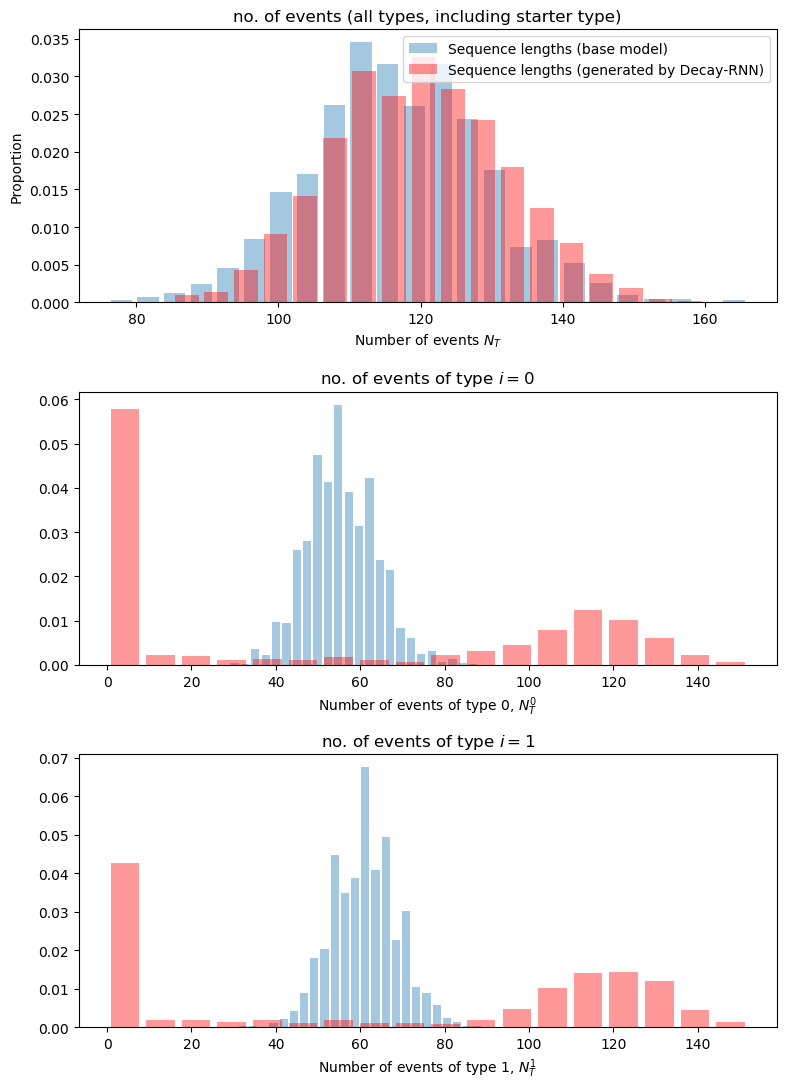

In [186]:
fig, axes = plt.subplots(process_dim + 1, 1, figsize=(8,5+process_dim*3), dpi=100)
ax0 = axes[0]
axt = axes[1:]
hist_opts = {
    "rwidth": 0.8,
    "alpha": 0.4,
    "density": True
}

_ = ax0.hist(seq_lengths, bins=2*int(seq_lengths.size(0)**(1/3)),
            label="Sequence lengths (base model)",
            **hist_opts)
_ = ax0.hist(gen_seq_lengths, bins=2*int(n_gen_seq**(1/3)),
            label="Sequence lengths (generated by {:})".format(MODEL_NAME),
            color='red', **hist_opts)
ax0.legend()
ax0.set_title('no. of events (all types, including starter type)')
ax0.set_ylabel('Proportion')
ax0.set_xlabel('Number of events $N_T$')
for i, ax in enumerate(axt):
    # get the sequence lengths for the event types
    typ_seq_lengths = (seq_types == i).sum(dim=0)
    gen_typ_seq_lengths = gen_seq_types_lengths[:, i]
    ax.hist(typ_seq_lengths, bins=2*int(typ_seq_lengths.size(0)**(1/3)),
            label="Sequence lengths (base model)",
            **hist_opts)
    ax.hist(gen_typ_seq_lengths,
            bins=2*int(gen_typ_seq_lengths.shape[0]**(1/3)),
            label="Sequence lengths (base model)",
            color='red', **hist_opts)
    ax.set_xlabel("Number of events of type {}, $N_T^{}$".format(i, i))
    ax.set_title('no. of events of type $i={}$'.format(i))

fig.tight_layout()

In [187]:
RESULT_BASEDIR = "../results"
extra_tag = "{}d".format(process_dim)
os.makedirs(RESULT_BASEDIR, exist_ok=True)
model_perf_indicator = "seq_length_distrib"
fig.savefig("{:}/{:}_{:}-{}-hidden_{}.pdf"
            .format(RESULT_BASEDIR, model_perf_indicator, MODEL_NAME, extra_tag, hidden_size))

The number of events does not fit.

In [189]:
def plot_events_and_intensity(event_times: torch.Tensor, seq_types: torch.Tensor,
                              hidden_states: torch.Tensor, event_decay: torch.Tensor):
    sequence_length = event_times.shape[0]
    print("no. of events: {}".format(sequence_length))
    evt_times = event_times.numpy()
    evt_types = seq_types.numpy()
    inp_size = model.input_size
    fig, ax = plt.subplots(1, 1, sharex=True, dpi=110,
                           figsize=(10,1))
    ax.set_ylim((-0.6, 1.6))
    ts_y = np.random.rand(sequence_length)
    inpt_size = model.input_size
    for k in range(inpt_size):
        mask = evt_types == k
        ax.scatter(evt_times[mask], ts_y[mask], s=9,
                   label="{}".format(k), alpha=0.7)
        ax.vlines(evt_times[mask], -0.6, 1.6, linewidth=0.3, linestyles='--', alpha=0.5)
    ax.legend()

no. of events: 108


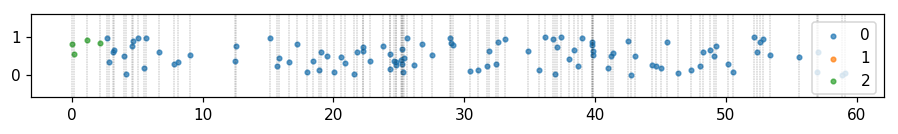

In [190]:
gen_evt_times, gen_evt_types, gen_event_intens, gen_event_decay = generate_sequence(model, tmax)
plot_events_and_intensity(gen_evt_times, gen_evt_types, gen_event_intens, gen_event_decay)

In [126]:
from models.decayrnn import read_predict
import torch.nn.functional as F

In [127]:
num_errors = 0

for index in range(500):
    oh_real, oh_pred, type_distrib = read_predict(
        model, times_tensor[:,index],
        onehot_types[:,index], seq_lengths[index])
    num_errors += int(not(oh_real.equal(oh_pred)))

In [128]:
print("Errors: {}/{}".format(num_errors, 500))

Errors: 258/500
